# Linear regression implementation and key insights

Есть три сходных между собой понятия, три сестры: интерполяция, аппроксимация и регрессия.
У них общая цель: из семейства функций выбрать ту, которая обладает определенным свойством.

Интерполяция — способ выбрать из семейства функций ту, которая проходит через заданные точки. Часто функцию затем используют для вычисления в промежуточных точках. Классические примеры: интерполяция полиномами Лагранжа, сплайн-интерполяция, многомерная интерполяция (билинейная, трилинейная, методом ближайшего соседа и т.д). Есть также родственное понятие экстраполяции — предсказание поведения функции вне интервала. Например, предсказание курса доллара на основании предыдущих колебаний — экстраполяция.

Аппроксимация — способ выбрать из семейства «простых» функций приближение для «сложной» функции на отрезке, при этом ошибка не должна превышать определенного предела. Аппроксимацию используют, когда нужно получить функцию, похожую на данную, но более удобную для вычислений и манипуляций (дифференцирования, интегрирования и т.п). При оптимизации критических участков кода часто используют аппроксимацию: если значение функции вычисляется много раз в секунду и не нужна абсолютная точность, то можно обойтись более простым аппроксимантом с меньшей «ценой» вычисления. Классические примеры включают ряд Тейлора на отрезке, аппроксимацию ортогональными многочленами, аппроксимацию Паде, аппроксимацию синуса Бхаскара и т.п.


Регрессия — способ выбрать из семейства функций ту, которая минимизирует функцию потерь. Последняя характеризует насколько сильно пробная функция отклоняется от значений в заданных точках. Если точки получены в эксперименте, они неизбежно содержат ошибку измерений, шум, поэтому разумнее требовать, чтобы функция передавала общую тенденцию, а не точно проходила через все точки. В каком-то смысле регрессия — это «интерполирующая аппроксимация»: мы хотим провести кривую как можно ближе к точкам и при этом сохранить ее максимально простой чтобы уловить общую тенденцию. За баланс между этими противоречивыми желаниями как-раз отвечает функция потерь (в английской литературе «loss function» или «cost function»).

Отмечу, что линейную регрессию называют линейной именно из-за линейной комбинации базисных функций — это не связано с самыми базисными функциями (они могут быть линейными или нет).

Регрессия с нами уже давно: впервые метод опубликовал Лежандр в 1805 году, хотя Гаусс пришел к нему раньше и успешно использовал для предсказания орбиты «кометы» (на самом деле карликовой планеты) Цереры. Существует множество вариантов и обобщений линейной регрессии: LAD, метод наименьших квадратов, Ridge регрессия, Lasso регрессия, ElasticNet и многие другие.

The Gauss-Markov theorem provides the foundation for ordinary least squares (OLS) regression, stating that under specific conditions, the OLS estimator is the Best Linear Unbiased Estimator (BLUE) of the coefficients in a linear regression model. 

Criteria Linear Regression Must Satisfy

1) Linearity in Parameters:
- The model must be linear in the coefficients $\beta_0, \beta_1, \ldots, \beta_n$, i.e., $y = X\beta + \epsilon$

2) Exogeneity (Unbiasedness):
- The error term $\epsilon$ must have an expected value of zero: $\mathbf{E}(\epsilon) = 0$.
- There should be no correlation between the predictors $X$ and the error term: $\mathbf{E}(\epsilon | X) = 0$.

- If this criteria fails, the estimated coefficients will systematically deviate from the true values, leading to biased predictions. 

3) Homoscedasticity:
- The error term $\epsilon$ should have constant variance $Var(\epsilon | X) = \sigma^2$. 

- If violated, inflates standard errors, causing unreliable hypothesis testing. 

4) No Autocorrelation:
- Errors should not be correlated with each other: $Cov(\epsilon_i, \epsilon_j) = 0$ for $i \neq j$. 

- If violated, leads to inefficient estimates and invalid inference. 

5) Full Rank of Predictor Matrix ($X$):
- The predictor variables must not be perfectly multicollinear. In matrix terms, $X^T X$ must be invertible. 

- If violated, makes coefficient estimates unstable and senstive to small data changes. 

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
# gradient descent solution

class GDLinearRegression:
    def __init__(self, learning_rate=0.01, tolerance=1e-8, regularization=None, alpha=0.01, l1_ratio=0.5, iteration = 20):
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.regularization = regularization
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.iteration = iteration

    def fit(self, X, y, X_val=None, y_val=None):
        n_samples, n_features = X.shape

        self.bias = 0
        self.weights = np.zeros(n_features)

        previous_db = 0
        previous_dw = np.zeros(n_features)

        self.train_errors = []
        self.val_errors = []

        iteration = 0

        while True:
            y_pred = X @ self.weights + self.bias

            # Gradients
            db = (1 / n_samples) * np.sum(y_pred - y)
            dw = (1 / n_samples) * X.T @ (y_pred - y)

            if self.regularization == "ridge":
                dw += (self.alpha / n_samples) * self.weights
            elif self.regularization == "lasso":
                dw += (self.alpha / n_samples) * np.sign(self.weights)
            elif self.regularization == "elasticnet":
                dw += (self.alpha / n_samples) * (self.l1_ratio * np.sign(self.weights) + (1 - self.l1_ratio) * self.weights)

            self.bias -= self.learning_rate * db
            self.weights -= self.learning_rate * dw

            abs_db_reduction = np.abs(db - previous_db)
            abs_dw_reduction = np.abs(dw - previous_dw)

            train_error = self.mse(y, y_pred)
            self.train_errors.append(train_error)

            if X_val is not None and y_val is not None:
                y_val_pred = X_val @ self.weights + self.bias
                val_error = self.mse(y_val, y_val_pred)
                self.val_errors.append(val_error)

            if abs_db_reduction < self.tolerance and abs_dw_reduction.all() < self.tolerance:
                break
            elif self.iteration < iteration:
                break

            previous_db = db
            previous_dw = dw
            iteration += 1

    def predict(self, X_test):
        return X_test @ self.weights + self.bias

    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

In [73]:
np.random.seed(42)
X = np.random.rand(200, 1) * 10
y = 3.5 * X[:, 0] + np.random.randn(200) * 2

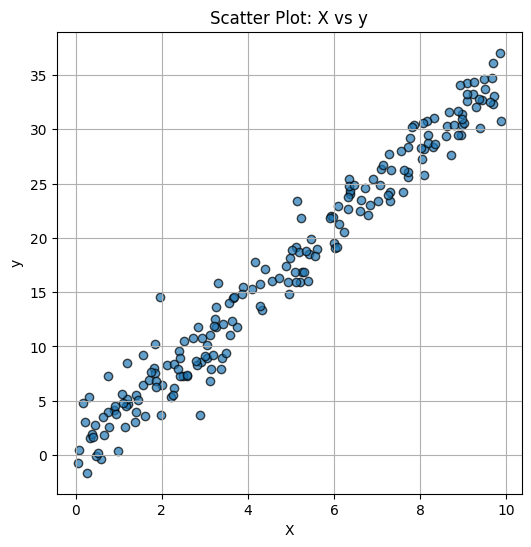

In [74]:
plt.figure(figsize=(6, 6))
plt.scatter(X, y, alpha=0.7, edgecolors="k")
plt.title("Scatter Plot: X vs y")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [76]:
linear_regression = GDLinearRegression(regularization='ridge')
linear_regression.fit(X_train, y_train)
y_test_pred = linear_regression.predict(X_test)

mse = linear_regression.mse(y_test, y_test_pred)

print(f'Linear Regression MSE score with GD: {mse}')

Linear Regression MSE score with GD: 2.9502323677284967


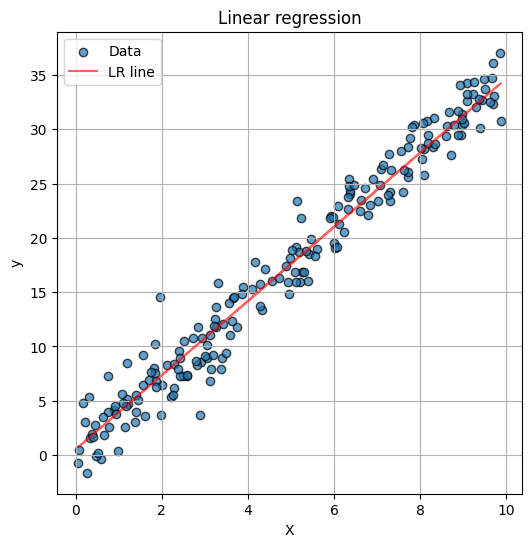

In [77]:
plt.figure(figsize=(6, 6))
plt.scatter(X, y, alpha=0.7, edgecolors="k", label = 'Data')
plt.plot(X, linear_regression.predict(X), alpha= 0.6, color = 'red', label = 'LR line')
plt.title("Linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

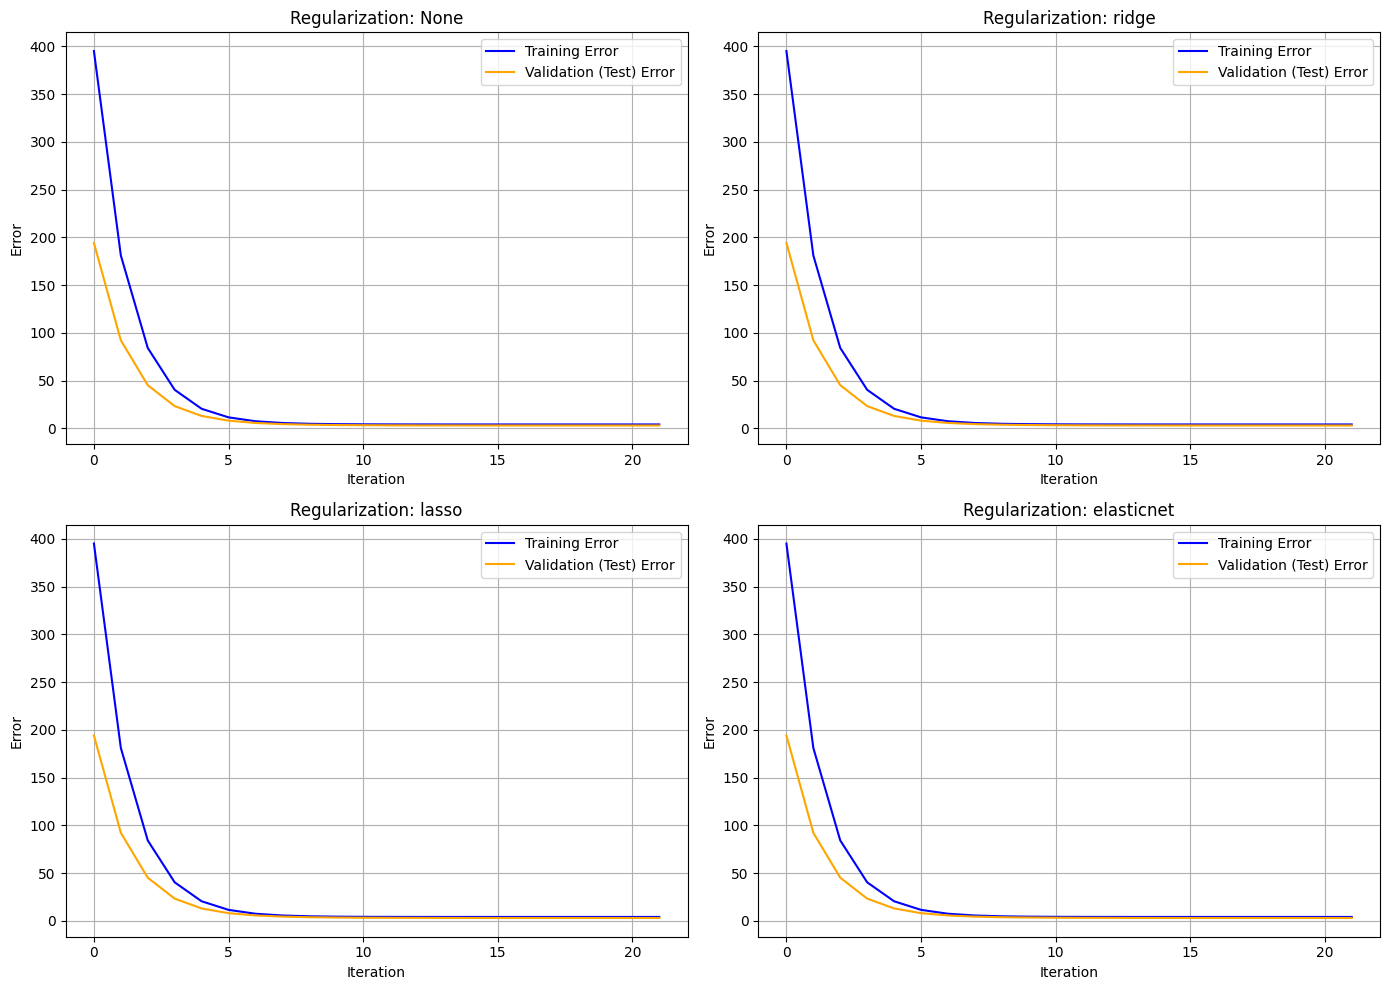

In [78]:
hyperparams = [
    {"regularization": None},
    {"regularization": "ridge"},
    {"regularization": "lasso"},
    {"regularization": "elasticnet"},
]

plt.figure(figsize=(14, 10))
for i, params in enumerate(hyperparams):
    model = GDLinearRegression(**params)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

    plt.subplot(2, 2, i + 1)
    plt.plot(model.train_errors, label="Training Error", color="blue")
    if model.val_errors:
        plt.plot(model.val_errors, label="Validation (Test) Error", color="orange")
    plt.title(f"Regularization: {params['regularization']}")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


### Correlated data

In [79]:
np.random.seed(42)
X1 = np.random.rand(200) * 10
X2 = 0.8 * X1 + np.random.randn(200) * 1.5 
X = np.column_stack((X1, X2))

y = 3.5 * X1 + 2.0 * X2 + np.random.randn(200) * 2 

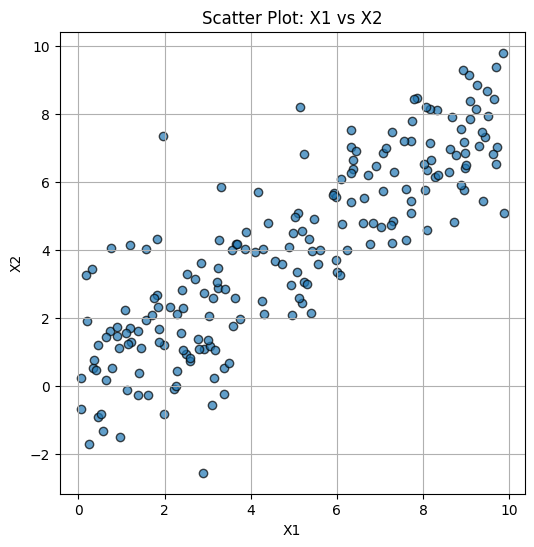

In [80]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.7, edgecolors="k")
plt.title("Scatter Plot: X1 vs X2")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

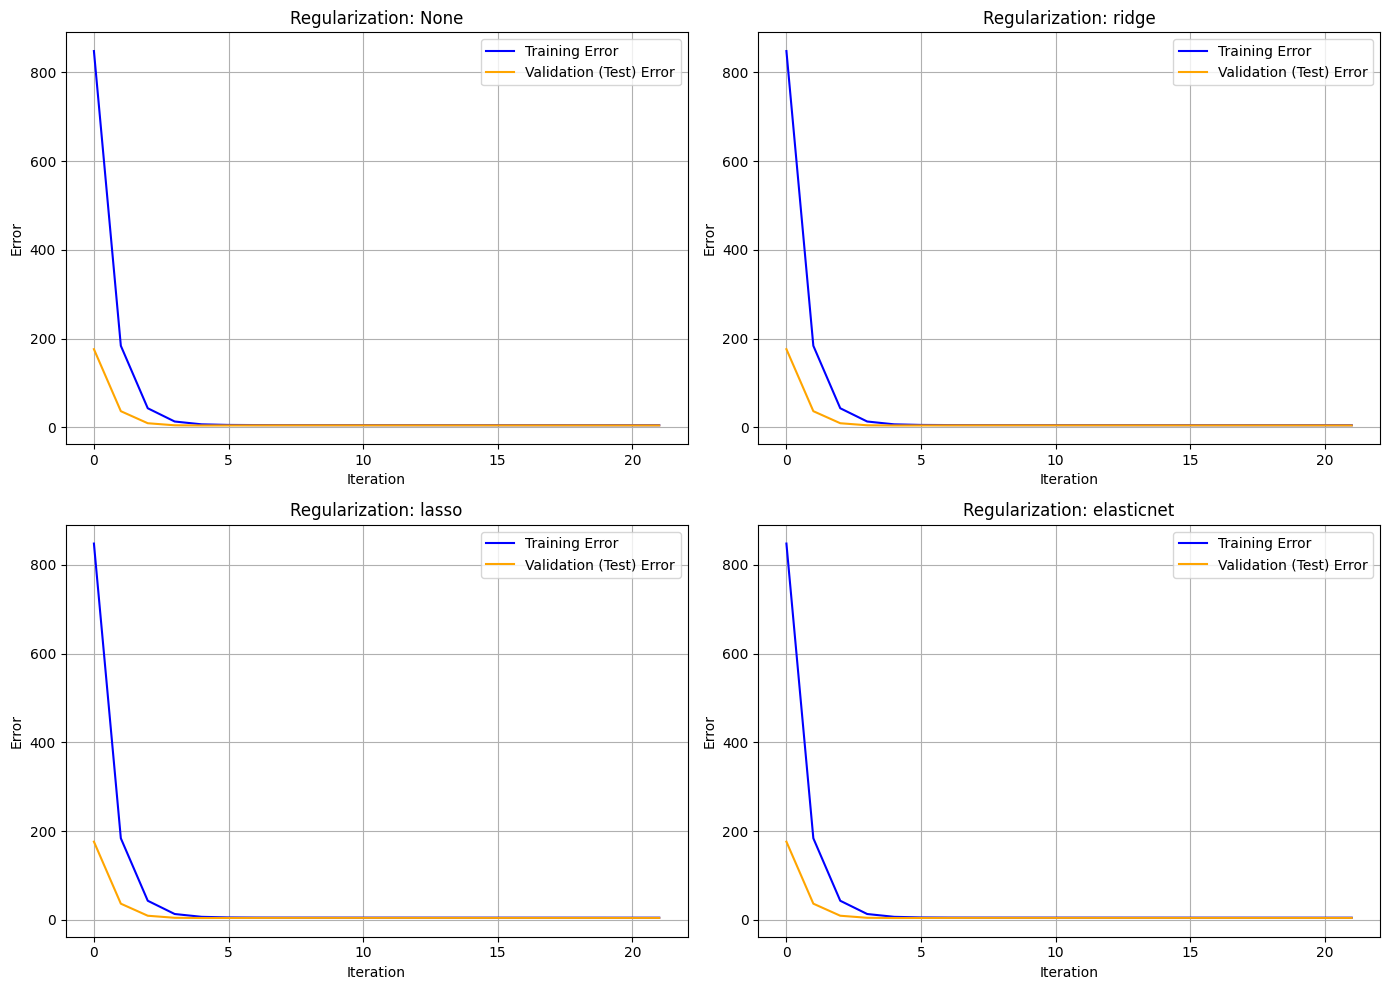

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

hyperparams = [
    {"regularization": None},
    {"regularization": "ridge"},
    {"regularization": "lasso"},
    {"regularization": "elasticnet"},
]

plt.figure(figsize=(14, 10))
for i, params in enumerate(hyperparams):
    model = GDLinearRegression(**params)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

    plt.subplot(2, 2, i + 1)
    plt.plot(model.train_errors, label="Training Error", color="blue")
    if model.val_errors:
        plt.plot(model.val_errors, label="Validation (Test) Error", color="orange")
    plt.title(f"Regularization: {params['regularization']}")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

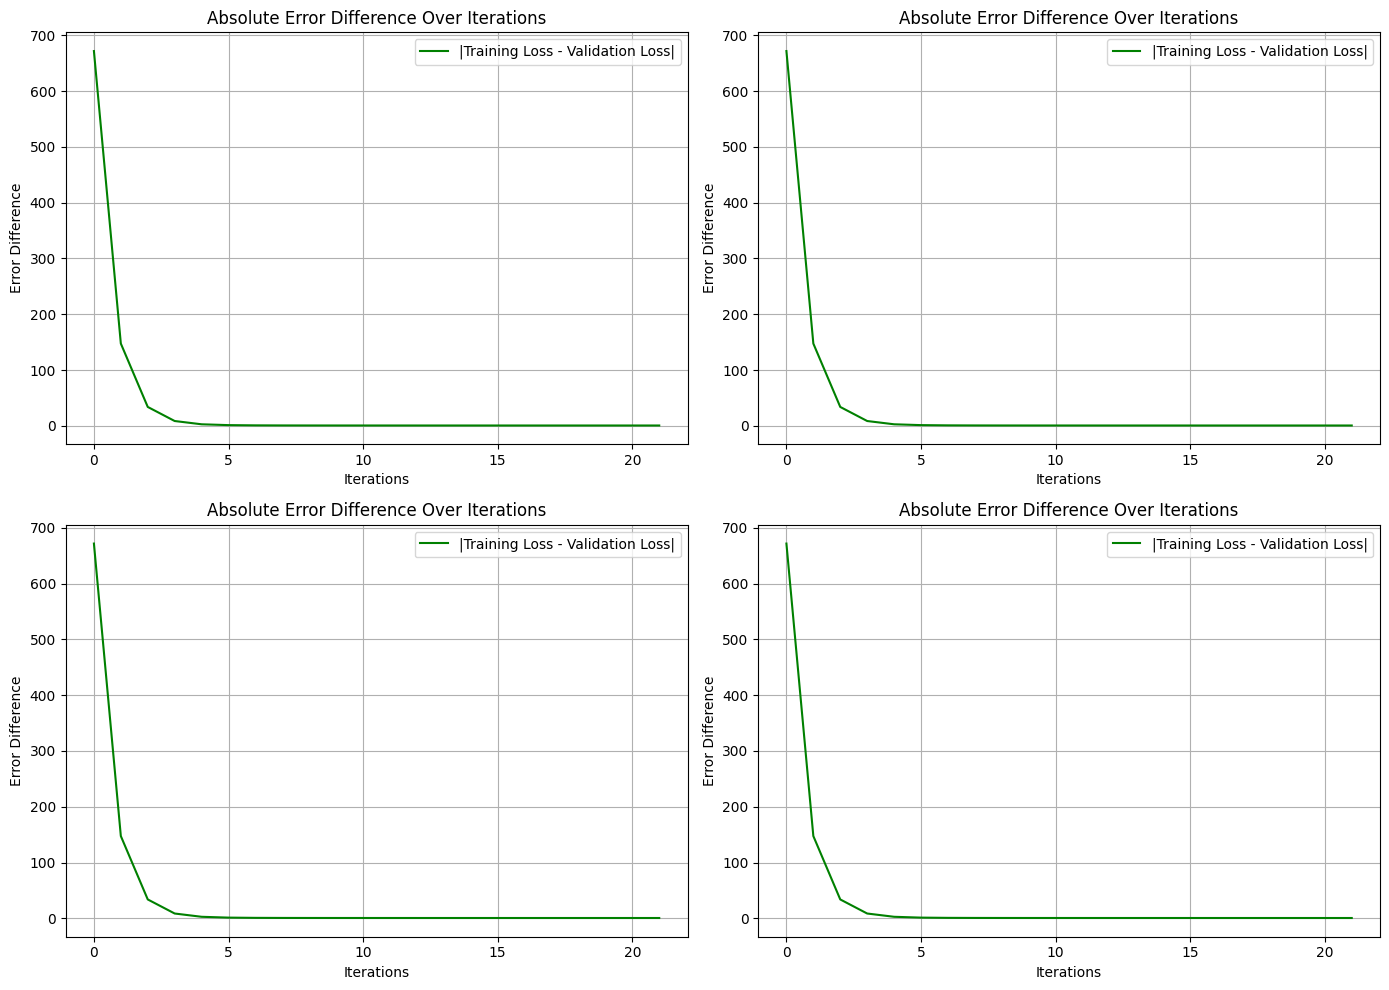

In [84]:
# Error difference 

plt.figure(figsize=(14, 10))
for i, params in enumerate(hyperparams):
    model = GDLinearRegression(**params)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

    plt.subplot(2, 2, i + 1)
    error_diff = np.abs(np.array(model.train_errors) - np.array(model.val_errors))
    plt.plot(error_diff, label="|Training Loss - Validation Loss|", color="green")
    plt.title("Absolute Error Difference Over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Error Difference")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

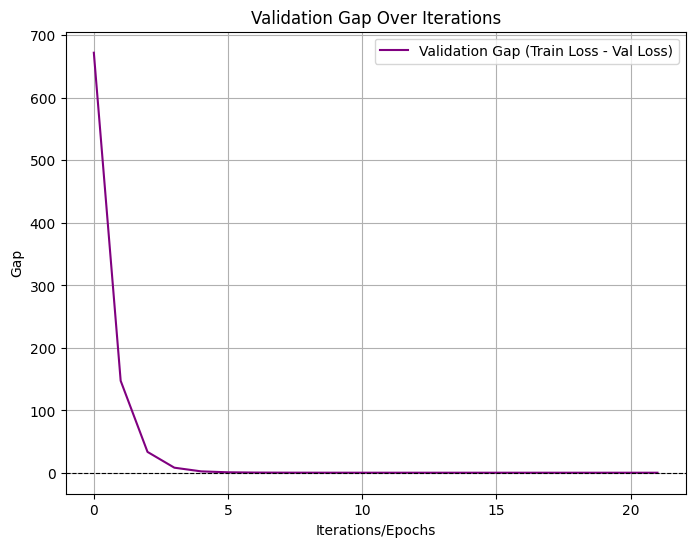

In [85]:
model = GDLinearRegression()
model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

validation_gap = np.array(model.train_errors) - np.array(model.val_errors)

plt.figure(figsize=(8, 6))
plt.plot(validation_gap, label="Validation Gap (Train Loss - Val Loss)", color="purple")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
plt.title("Validation Gap Over Iterations")
plt.xlabel("Iterations/Epochs")
plt.ylabel("Gap")
plt.legend()
plt.grid(True)
plt.show()


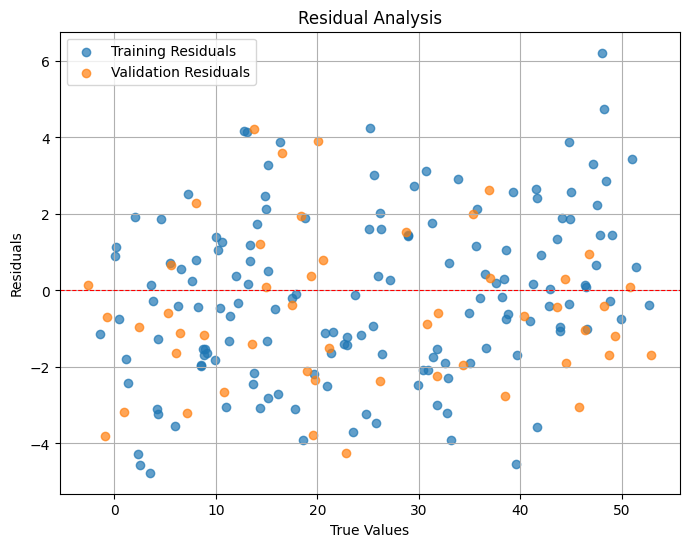

In [86]:
model = GDLinearRegression()
model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train - model.predict(X_train), label="Training Residuals", alpha=0.7)
plt.scatter(y_test, y_test - model.predict(X_test), label="Validation Residuals", alpha=0.7)
plt.axhline(y=0, color="red", linestyle="--", linewidth=0.8)
plt.title("Residual Analysis")
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.show()
